Select kernel `segment-anything`

Run this cell to import necessary packages and initialise SAM model and mask generator

In [8]:
# Import the necessary libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
from ultralytics import YOLO
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import display
from IPython.display import clear_output
import yaml
from ultralytics import YOLO
import glob
import pickle

from notebooks.sam2yolo_functions import *

sam_checkpoint = "sam_vit_h_4b8939.pth" # Path to the checkpoint file
model_type = "vit_h" # Model type

device = "cuda" if torch.cuda.is_available() else "cpu" # Use GPU if available, otherwise use CPU

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) # Load the model
sam.to(device=device) # Move the model to the device

mask_generator = SamAutomaticMaskGenerator(sam) # Create a mask generator

# Main Program

Before running this, ensure the workspace has no `dataset` folder and `images` has no other images that you don't want in the dataset
This cell extracts individual frames from a specified video, and outputs it to the specified `img_path`. It then splits the images into an 80/20 train/val set randomly into the `dataset` folder and performs segmentations on each set using the SAM model (vit_h)
The segmentation mask and relevant data are stored in `train_mask_list` and `valid_mask_list`.

In [10]:
# Specify labels
labels = {
    0: "Aircraft",
    1: "Airtug",
    2: "Next segment",
    3: "Next frame"
}

# specify the source videos to use
vid_path = "1-source/"
# specify where the images will go
img_path = "2-source-extracted/"
# specify where the temporary holding folder for the generated dataset will be
ds_path = "3-dataset/"

In [19]:
# extracts the frames from the videos in the vid_path and outputs them to the img_path as jpgs
# then splits the images into an 80/20 train/val set randomly into the ds_path folder
# performs segmentations on each set using the SAM model (vit_h)
# the segmentation mask and relevant data are stored in train_mask_list and valid_mask_list
train_mask_list, valid_mask_list = load_images_from_video(img_path, vid_path, frame_interval=300)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '3-dataset\\train\\images'

This cell will run the main program. The training sets and labels generated for this will be stored in `3-dataset`. 

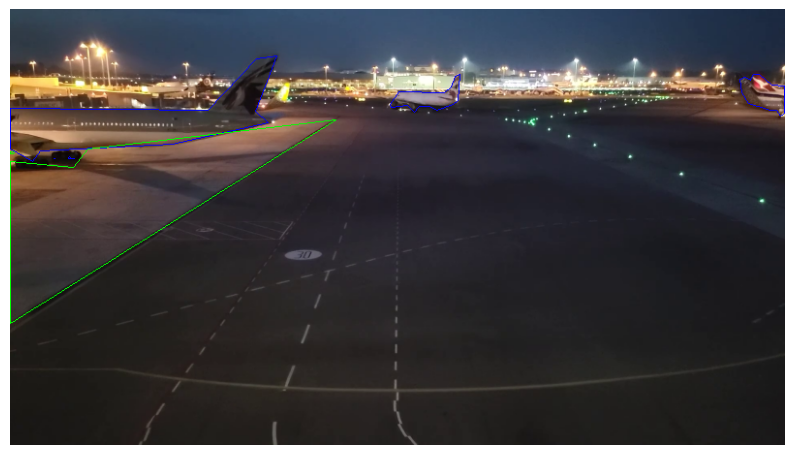

KeyboardInterrupt: Interrupted by user

In [7]:
# all the images in the ds_path folder will now be annotated by the user
# once done, the annotations will be outputted as txt files in the ds_path/train/labels and ds_path/valid/labels folders
# images with no annotations will be deleted along with their corresponding txt files
main_program(train_mask_list, valid_mask_list, labels)

---
Move the data collected into the `dataset` folder. 

In [31]:
move_files("3-dataset/train/images", "3-dataset/train/labels", "dataset/train/images", "dataset/train/labels") # move the training data
move_files("3-dataset/valid/images", "3-dataset/valid/labels", "dataset/valid/images", "dataset/valid/labels") # move the validation data
move_source_vid("1-source", "dataset/source") # move the source videos

Clear `1-source`, `2-source-extracted`, and `3-dataset`. If you want to add more dataset, repeat the above process. 

In [32]:
if(input("Are you sure you want to clear the source videos, extracted images, and dataset? (y/n): ")) == 'y':
    clear_directory("1-source")
    clear_directory("2-source-extracted")
    clear_directory("3-dataset")

Else, move on to the next cell to create the `yaml` file to proceed with YOLO training.

In [10]:
abspath_ds = os.path.abspath('dataset') # the yolo yaml file requires the absolute path of the dataset folder
create_yaml(labels, abspath_ds) # create the yaml file

# YOLO

Training

In [ ]:
model = YOLO('yolov8x-seg.pt') # load existing model
model.train(data="dataset/data.yaml", epochs=300, imgsz=640, batch=2) # train the model with previously generated data

New https://pypi.org/project/ultralytics/8.0.114 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.110  Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16384MiB)
yolo\engine\trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=dataset/data.yaml, epochs=100, patience=50, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=Fa

Predicting

In [6]:
trained_model = YOLO(r'C:\Users\Adrian\Desktop\projects\sam-2-yolo\runs\segment\train12\weights\best.pt') # load the trained model
results = trained_model.predict(source="test.MOV", show=True) 



    WARNING  stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/2672) C:\Users\Adrian\Desktop\projects\sam-2-yolo\test.MOV: 384x640 1 plane, 2 airtugs, 304.4ms
video 1/1 (2/2672) C:\Users\Adrian\Desktop\projects\sam-2-yolo\test.MOV: 384x640 1 plane, 2 airtugs, 26.0ms
video 1/1 (3/2672) C:\Users\Adrian\Desktop\projects\sam-2-yolo\test.MOV: 384x640 1 plane, 2 airtugs, 39.0ms
video 1/1 (4/2672) C:\Users\Adrian\Desktop\projects\sam-2-yolo\test.MOV: 384x640 1 plane, 2 airtugs, 33.0ms
video 1/1 (5/2672) C:\Users\

KeyboardInterrupt: 